In [1]:
import cv2
import string
import numpy as np
import os
from keras import layers #for building layers of neural net
from keras.models import Model
from keras.models import load_model
from keras import callbacks #for training logs, saving to disk periodically
from matplotlib import pyplot as plt

2022-07-10 12:04:45.642603: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-07-10 12:04:45.642628: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


## Reconhecedor CAPTCHA

CAPTCHA significa “Completely Automated Public Turing test to tell Computers and Humans Apart” (Teste de Turing Público Completamente Automatizado para diferenciar computadores e humanos) e como o nome sugere é um modo de evitar que computadores façam ações por si mesmos que orignalmente requerem o manuseio por humanos, como um sistema de votos online por exemplo. Porém, utilizando o conceito de deep learning e visão computacional, o CAPTCHA pode ser "derrotado". Tal objetivo pode ser atingido com a ajuda de Convolutional Neural Networks(CNN). Uma CNN é um algoritmo de deep learning que recebe uma imagem como entrada e, em seguida, atribui algum valor a várias *features* da imagem. Seu principal objetivo é transformar as imagens em um formato muito mais fácil de processar, sem perder *features* essenciais para obter uma previsão otimizada.

### Descrição do Dataset

O conjunto de dados usado para este projeto consiste em 10000 imagens .jpg de CAPTCHA baseado em texto. Cada imagem do conjunto de dados tem um conjunto de 6 caracteres e o conjunto de caracteres é definido como todas as letras maiúsculas e dígitos de 0 a 9. Portanto, um total de 36 caracteres está presente no conjunto de caracteres.
O conjunto de dados é separado em treinamento (utilizado para treinar o modelo), com 8000 imagens, validação com 1000 imagens e teste com 1000 imagens. O aprendizado é feito apenas com a utilização das imagens contidas no diretório treinamento e a validação de parâmetros é feita apenas com imagens do diretório validação. As imagens do diretório teste são utilizadas para avaliação do método.

### Etapas

1. Pré processamento dos dados


In [2]:
IMG_WIDTH = 180
IMG_HEIGHT = 50
NUM_TRAINING_IMGS = 8000
NUM_TEST_IMGS = 1000

NUM_CHARS_IN_CAPTCHA = 6

IMG_SHAPE = (IMG_HEIGHT, IMG_WIDTH, 1) # 1 is the number of channels

CHARACTERS = string.ascii_uppercase + "0123456789"
N_CHARS = len(CHARACTERS)
N_CHARS

36

NZKAGQ
(6, 36)


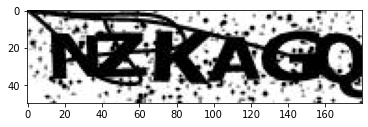

In [3]:
def get_labels():
    labels = []
    sorted = os.listdir("dados/CAPTCHA-10k/labels10k")
    sorted.sort()
    
    for i in sorted:
        captcha = open("dados/CAPTCHA-10k/labels10k/" + i, 'r').read().strip()
        labels.append(captcha)

    return labels

def get_X_and_y(type, labels):
    n = NUM_TRAINING_IMGS
    shift = 0

    if type == "validacao":
        n = NUM_TEST_IMGS
        shift = 8000

    if type == "teste":
        n = NUM_TEST_IMGS
        shift = 9000
    

    X = np.zeros((n, IMG_HEIGHT, IMG_WIDTH, 1))
    y = np.zeros((NUM_CHARS_IN_CAPTCHA, n, N_CHARS))

    files = os.listdir("dados/CAPTCHA-10k/" + type)
    files.sort()

    for i, pic in enumerate(files):
        img = cv2.imread(os.path.join("dados/CAPTCHA-10k/" + type, pic), cv2.IMREAD_GRAYSCALE) #Read image in grayscale
        pic_target = labels[i + shift]

        if len(pic_target) < 7:
            img = img / 255.0 #scales the image between 0 and 1
            img = np.reshape(img, (IMG_HEIGHT, IMG_WIDTH, 1)) 

            target=np.zeros((NUM_CHARS_IN_CAPTCHA, N_CHARS)) #creates an array of size 5*36 with all entries 0

            for j, k in enumerate(pic_target):
                
                #j iterates from 0 to 4(5 letters in captcha)
                #k denotes the letter in captcha which is to be scanned
                index = CHARACTERS.find(k) #index stores the position of letter k of captcha in the character string
                target[j, index] = 1 #replaces 0 with 1 in the target array at the position of the letter in captcha
                
                # if (pic_target) == "RNINIC":
                #     print(j)
                #     print(k)
                #     print(index)
                #     print(target[j])

            X[i] = img
            y[:,i] = target

    return X, y

labels = get_labels()
X_training, y_training = get_X_and_y(type="treinamento", labels=labels)

plt.imshow(X_training[700], cmap=plt.get_cmap("gray"))
print(labels[0 + 700])
print(y_training[:,0].shape)

## Create Model

In [4]:
def createModel():
    img = layers.Input(shape=IMG_SHAPE) # Get image as an input of size IMG_SHAPE
    conv1 = layers.Conv2D(16, (3, 3), padding='same', activation='relu')(img) #50*180
    
    mp1 = layers.MaxPooling2D(padding='same')(conv1)  # 25*90
    conv2 = layers.Conv2D(32, (3, 3), padding='same', activation='relu')(mp1)
    
    mp2 = layers.MaxPooling2D(padding='same')(conv2)  # 13*45
    conv3 = layers.Conv2D(32, (3, 3), padding='same', activation='relu')(mp2)
    
    mp3 = layers.MaxPooling2D(padding='same')(conv3)  # 13*45
    conv4 = layers.Conv2D(32, (3, 3), padding='same', activation='relu')(mp3)

    bn = layers.BatchNormalization()(conv4) #to improve the stability of model
    mp4 = layers.MaxPooling2D(padding='same')(bn)  # 7*23
    
    flat = layers.Flatten()(mp4) #convert the layer into 1-D

    outs = []
    for _ in range(NUM_CHARS_IN_CAPTCHA): # 6 letters of captcha
        dens1 = layers.Dense(64, activation='relu')(flat)
        drop = layers.Dropout(0.5)(dens1) #drops 0.5 fraction of nodes
        res = layers.Dense(N_CHARS, activation='sigmoid')(drop)

        outs.append(res) #result of layers
    
    # Compile model and return it
    model = Model(img, outs) #create model
    model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=["accuracy"])
    return model

In [5]:
model = createModel()
model.summary()

2022-07-10 12:04:49.720182: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-07-10 12:04:49.720206: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-07-10 12:04:49.720227: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (luizcouto-X510URR): /proc/driver/nvidia/version does not exist
2022-07-10 12:04:49.720407: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 50, 180, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 conv2d (Conv2D)                (None, 50, 180, 16)  160         ['input_1[0][0]']                
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 25, 90, 16)   0           ['conv2d[0][0]']                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 25, 90, 32)   4640        ['max_pooling2d[0][0]']      

In [6]:
X_validation, y_validation = get_X_and_y(type="validacao", labels=labels)

hist = model.fit(X_training, [y_training[0], y_training[1], y_training[2], y_training[3], y_training[4], y_training[5]], 
                batch_size=32, epochs=25, 
                validation_data=(X_validation, [y_validation[0], y_validation[1], y_validation[2], y_validation[3], y_validation[4], y_validation[5]]))

Epoch 1/25
250/250 [==============================] - 25s 93ms/step - loss: 21.5526 - dense_1_loss: 3.5928 - dense_3_loss: 3.5924 - dense_5_loss: 3.5925 - dense_7_loss: 3.5897 - dense_9_loss: 3.5930 - dense_11_loss: 3.5922 - dense_1_accuracy: 0.0286 - dense_3_accuracy: 0.0342 - dense_5_accuracy: 0.0250 - dense_7_accuracy: 0.0308 - dense_9_accuracy: 0.0338 - dense_11_accuracy: 0.0291 - val_loss: 21.4855 - val_dense_1_loss: 3.5795 - val_dense_3_loss: 3.5855 - val_dense_5_loss: 3.5812 - val_dense_7_loss: 3.5793 - val_dense_9_loss: 3.5800 - val_dense_11_loss: 3.5799 - val_dense_1_accuracy: 0.0310 - val_dense_3_accuracy: 0.0140 - val_dense_5_accuracy: 0.0300 - val_dense_7_accuracy: 0.0290 - val_dense_9_accuracy: 0.0310 - val_dense_11_accuracy: 0.0230
Epoch 2/25
250/250 [==============================] - 23s 92ms/step - loss: 21.4831 - dense_1_loss: 3.5818 - dense_3_loss: 3.5799 - dense_5_loss: 3.5801 - dense_7_loss: 3.5810 - dense_9_loss: 3.5789 - dense_11_loss: 3.5814 - dense_1_accuracy: 0

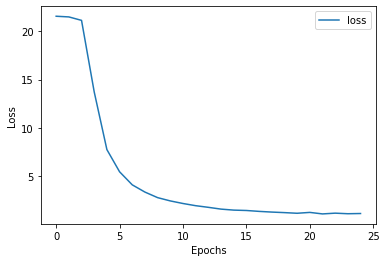

In [9]:
#graph of loss vs epochs
for label in ["loss"]:
  plt.plot(hist.history[label],label=label)
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

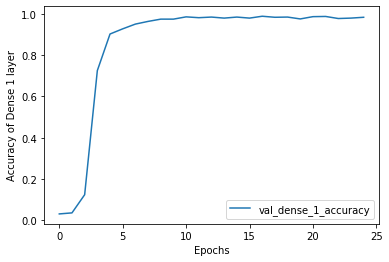

In [11]:

#graph of accuracy of dense_2 vs epochs
for label in ["val_dense_1_accuracy"]:
  plt.plot(hist.history[label],label=label)
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Accuracy of Dense 1 layer")
plt.show()



JW4CZF
1/1 [==============================] - 0s 25ms/step


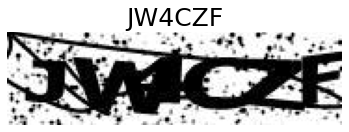

In [22]:
def predict(filepath, model):
    img = cv2.imread(filepath, cv2.IMREAD_GRAYSCALE)

    if img is not None:
        img = img / 255.0
    else:
        print("Not detected");

    res = np.array(model.predict(img[np.newaxis, :, :, np.newaxis])) #np.newaxis=1 
    #added this bcoz x_train 970*50*200*1
    #returns array of size 1*5*36 
    result = np.reshape(res, (NUM_CHARS_IN_CAPTCHA, 36)) #reshape the array
    k_ind = []
    for i in result:
        k_ind.append(np.argmax(i)) #adds the index of the char found in captcha

    capt = '' #string to store predicted captcha
    for k in k_ind:
        capt += CHARACTERS[k] #finds the char corresponding to the index
    return capt

def show_prediction(img, predicted):
    img = cv2.imread(img, cv2.IMREAD_GRAYSCALE)
    plt.title(predicted, fontsize=25)
    plt.imshow(img, cmap=plt.get_cmap("gray"))
    plt.axis("off")

print(labels[9000])
predicted = predict("dados/CAPTCHA-10k/teste/009001.jpg", model)
show_prediction("dados/CAPTCHA-10k/teste/009001.jpg", predicted)

1/1 [==============================] - 0s 23ms/step


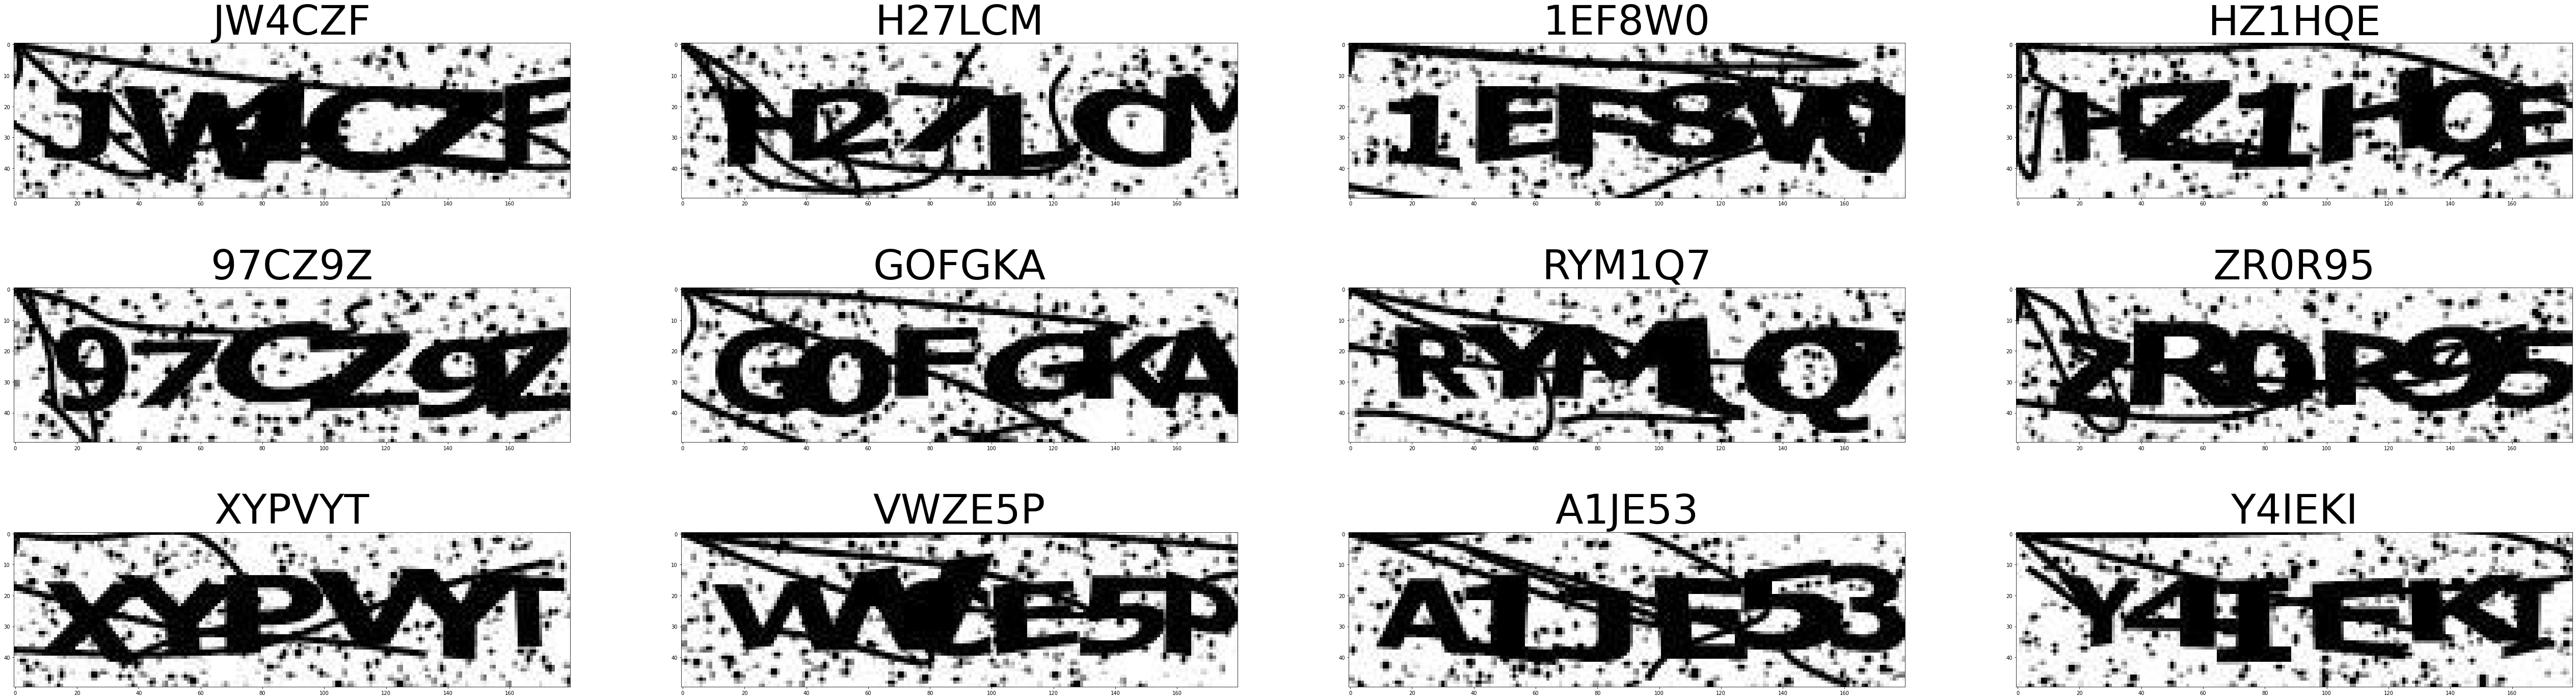

In [56]:
def show_test_sample(model):
    files = os.listdir("dados/CAPTCHA-10k/teste")
    files.sort()

    fig = plt.figure(figsize=(IMG_WIDTH/2,IMG_HEIGHT/2))
    columns = 4
    rows = 3
    for i in range(1,columns*rows + 1):
        path = os.path.join("dados/CAPTCHA-10k/teste", files[i-1])
        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
        predicted = predict(path, model)
        
        x = fig.add_subplot(rows, columns, i)
        x.set_title(predicted, fontsize = 80)
        plt.imshow(img, cmap=plt.get_cmap("gray"))
    
    plt.show()


show_test_sample(model)

In [38]:
def run_test(model, labels):
    files = os.listdir("dados/CAPTCHA-10k/teste")
    files.sort()
    shift = 9000

    predictions = []
    targets = []

    for i, pic in enumerate(files):
        path = os.path.join("dados/CAPTCHA-10k/teste", pic)
        
        predicted = predict(path, model)
        predictions.append(predicted)
        
        target = labels[shift + i]
        targets.append(target)

    return predictions, targets

In [39]:
predictions, targets = run_test(model, labels)

1/1 [==============================] - 0s 25ms/step


In [60]:
def diff_letters(a,b):
    return sum ( a[i] != b[i] for i in range(len(a)) )

equals = 0
total_diff = 0
recognition = []
for i in range(len(predictions)):
    diff = diff_letters(predictions[i], targets[i])
    if diff == 0:
        equals += 1

    total_diff += diff
    recognition.append(NUM_CHARS_IN_CAPTCHA - diff)

print("Porcentagem de CAPTCHAS completamente reconhecidos (todos os 6 caracteres):", equals/NUM_TEST_IMGS * 100)
print("Porcentagem de caracteres reconhecidos:", (1 - (total_diff/(NUM_TEST_IMGS*6))) * 100)


Porcentagem de CAPTCHAS completamente reconhecidos (todos os 6 caracteres): 67.9
Porcentagem de caracteres reconhecidos: 93.43333333333334


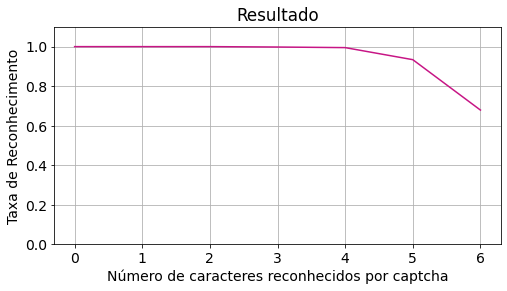

In [71]:
x = [0,1,2,3,4,5,6]
y = []
for k in range(0, NUM_CHARS_IN_CAPTCHA+1):
    y.append(sum(i >= k for i in recognition) / 1000)

plt.rcParams.update({'font.size':14})
plt.rcParams["figure.figsize"] = (8,4)
fig, ax = plt.subplots()
plt.title("Resultado")
ax.set_ylim(bottom=0, top=1.1)
plt.xlabel("Número de caracteres reconhecidos por captcha")
plt.ylabel("Taxa de Reconhecimento")
plt.grid()
plt.plot(x, y, color = 'mediumvioletred')
plt.show()

